## In-class hands-on activity: Model Evaluation

### Heart Failure Prediction
Original dataset from <https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data>


走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數或程式片段，讓整個檔案能正確的執行。

課程名稱: 統計學習與深度學習。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_column', 500)
pd.set_option('display.max_rows', 5000)


### 資料說明 (From the original data provider)

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

### Attribute Information
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]


In [2]:
# Start with data loading and showing sample data
df=pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# make sure the data types are reasonable
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [4]:
df.HeartDisease.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [5]:
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df_wc=pd.get_dummies(df,columns=cat_cols, drop_first=False)
df_wc.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True


In [6]:
# split training and test
random.seed(1001)
np.random.seed(1001)
mask1 = np.random.rand(len(df_wc)) < 0.9
df_wc_train = df_wc[mask1].copy()
df_wc_test = df_wc[~mask1].copy()

target = 'HeartDisease'
featnames = df_wc.columns.to_list()
featnames.remove(target)

print("Features to be include in the model", featnames)

Features to be include in the model ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


In [7]:
df_wc_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000
mean,53.356213,132.352663,197.124260,0.237870,137.066272,0.889941,0.555030
std,9.381575,18.613585,110.549221,0.426031,25.437506,1.073333,0.497257
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,171.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,222.000000,0.000000,138.000000,0.500000,1.000000
75%,60.000000,140.000000,266.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Feature value transformation

In [8]:
X_train = df_wc_train[featnames].values
y_train = df_wc_train[target].values

X_test = df_wc_test[featnames].values
y_test = df_wc_test[target].values

mm_scaler=preprocessing.MinMaxScaler()
X_train=mm_scaler.fit_transform(X_train)
X_test=mm_scaler.transform(X_test)

### Fitting Logistic Regression


In [9]:
clf=linear_model.LogisticRegressionCV()
# clf=linear_model.LogisticRegression(C=0.0464)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_predprob = clf.predict_proba(X_test)

print("First five features and coefficients")
for coef, fname in zip(clf.coef_.flatten(), featnames[0:5]):
    print(f"{fname:12s}: {coef:.4f}")

print("---")
print(f"The regularization coefficient is {clf.C_[0]:.4f}")

print("---")
print(metrics.classification_report(y_test, y_pred, digits=4))

First five features and coefficients
Age         : 0.0811
RestingBP   : 0.0103
Cholesterol : -0.0796
FastingBS   : 0.1846
MaxHR       : -0.0993
---
The regularization coefficient is 0.0060
---
              precision    recall  f1-score   support

           0     0.9286    0.7647    0.8387        34
           1     0.8222    0.9487    0.8810        39

    accuracy                         0.8630        73
   macro avg     0.8754    0.8567    0.8598        73
weighted avg     0.8718    0.8630    0.8613        73



accuracy = 0.8286

for the positive cases, precision = 0.8136, recall = 0.8727, F1 = 0.8421.

### ROC Curve (Step 1)

Plot ROC Curve by yourself.

Create a numpy array that contain predicted value and ground truth.

In [10]:
yymat = np.hstack((y_predprob[:,1].reshape(-1,1), y_test.reshape(-1, 1)))
print("Show example rows of the yymat")
yymat[0:10, :]

Show example rows of the yymat


array([[0.75737309, 1.        ],
       [0.64620793, 1.        ],
       [0.51038649, 0.        ],
       [0.33520565, 0.        ],
       [0.31664413, 0.        ],
       [0.62870666, 1.        ],
       [0.64846929, 1.        ],
       [0.7938516 , 1.        ],
       [0.77050691, 1.        ],
       [0.25316691, 0.        ]])

### TODO
Sort yymat so that it is ordered from large to small by column 0. 

Hint: Make use of np.argsort()

In [11]:
# TODO

sorted_idx = np.argsort(yymat[:, 0])[::-1]
yymat = yymat[sorted_idx]

yymat[0:10, :]

array([[0.81718792, 1.        ],
       [0.80246136, 1.        ],
       [0.80187488, 1.        ],
       [0.80013067, 1.        ],
       [0.79497753, 1.        ],
       [0.7938516 , 1.        ],
       [0.78068915, 1.        ],
       [0.77255494, 1.        ],
       [0.77050691, 1.        ],
       [0.76838576, 1.        ]])

### Sanity Check

```
array([[0.81718792, 1.        ],
       [0.80246136, 1.        ],
       [0.80187488, 1.        ],
       [0.80013067, 1.        ],
       [0.79497753, 1.        ],
       [0.7938516 , 1.        ],
       [0.78068915, 1.        ],
       [0.77255494, 1.        ],
       [0.77050691, 1.        ],
       [0.76838576, 1.        ]])

```


### ROC Curve (Step 2)

Compute false positive rate and true positive rate and plot the ROC curve. 

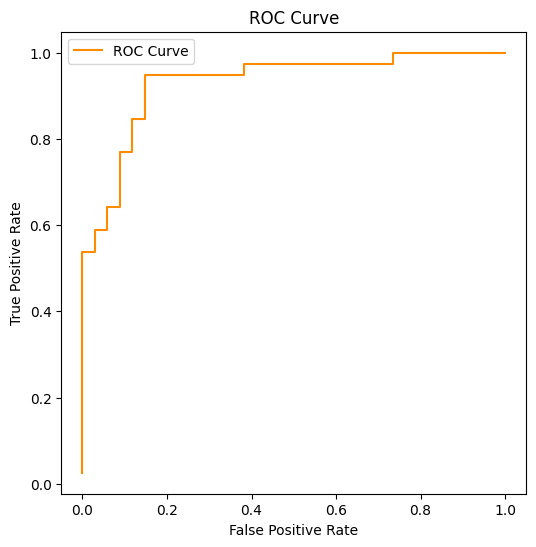

In [12]:
# TODO
thresholds = np.unique(yymat[:, 0])[::-1]
tpr_list = []
fpr_list = []

P = np.sum(yymat[:, 1] == 1)
N = np.sum(yymat[:, 1] == 0)

for thresh in thresholds:
    y_pred = (yymat[:, 0] >= thresh).astype(int)
    TP = np.sum((y_pred == 1) & (yymat[:, 1] == 1))
    FP = np.sum((y_pred == 1) & (yymat[:, 1] == 0))
    TPR = TP / P if P > 0 else 0
    FPR = FP / N if N > 0 else 0
    tpr_list.append(TPR)
    fpr_list.append(FPR)

plt.figure(figsize=(6, 6))
plt.plot(fpr_list, tpr_list, label='ROC Curve', color='darkorange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



### Sanity Check

The ROC curve should look like:

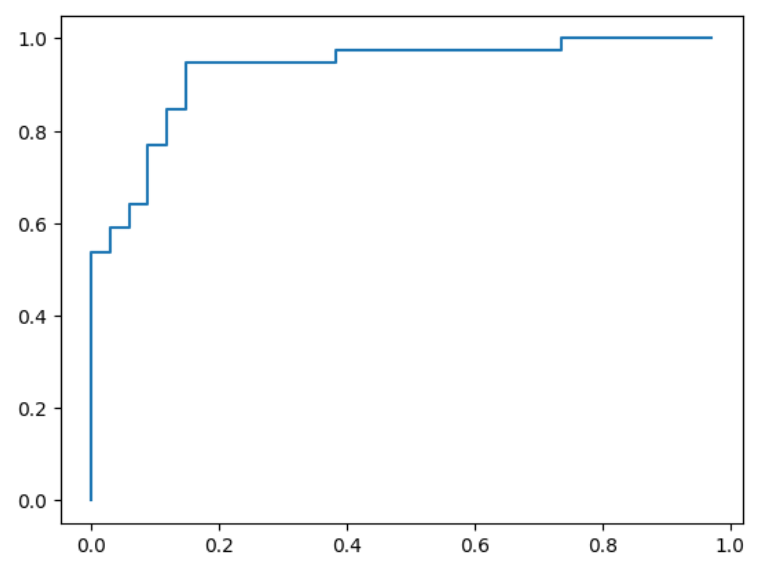

### ROC Curve using sklearn

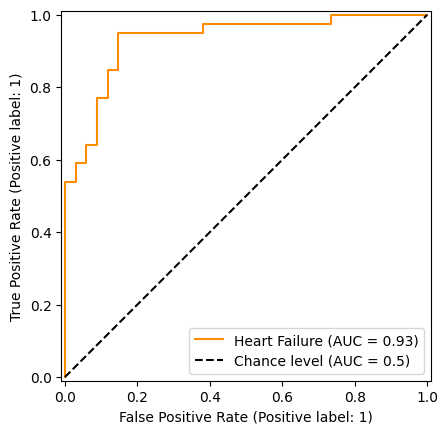

In [13]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(y_test, y_predprob[:,1], 
                                           name="Heart Failure",   
                                           color="darkorange",  
                                           plot_chance_level=True,)

# Part2: Multi-Class Classifier Performance Evaluation

Evaluating multi-class classifiers are conceptually similar to the binary counterpart. However, there are some aspects that are unique to multi-class classifiers. We are going to explore this scenario below. 

In [14]:
# Some of imports are duplicates. Should clean this up sometime.  

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# from sklearn.linear_model import LogisticRegression, 
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import neighbors
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing import label_binarize

# Set random seed for reproducibility
np.random.seed(242)

# Configure plot aesthetics
plt.style.use('seaborn-v0_8')
%matplotlib inline

### Generating a Synthetic Dataset

We'll start by creating a synthetic balanced dataset with 3 classes using the `make_classification` function from scikit-learn.

In [15]:
# Generate synthetic balanced dataset
X, y = make_classification(n_samples=1000, n_classes=3, n_features=20, n_informative=15, 
                          n_redundant=5, random_state=422, n_clusters_per_class=1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check class distribution
print("Class distribution in balanced training set:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution in balanced test set:")
print(pd.Series(y_test).value_counts())

Class distribution in balanced training set:
2    238
1    232
0    230
Name: count, dtype: int64

Class distribution in balanced test set:
0    106
1    100
2     94
Name: count, dtype: int64


## Training Classifiers

We'll train three classifiers: Logistic Regression, K-Nearest Neighbors (KNN), and a Random Classifier (DummyClassifier with 'uniform' strategy).

In [16]:
# Initialize classifiers

clf_lr = linear_model.LogisticRegressionCV()
clf_dummy = DummyClassifier(strategy='uniform', random_state=42)

# Train classifiers
clf_lr.fit(X_train, y_train)
clf_dummy.fit(X_train, y_train)

# Make predictions
y_pred_lr = clf_lr.predict(X_test)
y_pred_dummy = clf_dummy.predict(X_test)

### Performance Metrics

Compute accuracy, classification reports, and average precision for each classifier.

Compare the average precision value and the averaged per-class precision. How do you make sense of these values?



In [17]:
# TODO

# Logistic Regression
print("Logistic Regression - Dataset")
print("Overall Accuracy:", round(metrics.accuracy_score(y_test, y_pred_lr), 3))
print("Average Precision:", round(metrics.average_precision_score(label_binarize(y_test, classes=[0,1,2]), clf_lr.predict_proba(X_test)), 3))
print(metrics.classification_report(y_test, y_pred_lr, digits=2))

# Random Classifier
print("\nRandom Classifier - Dataset")
print("Overall Accuracy:", round(metrics.accuracy_score(y_test, y_pred_dummy), 3))
print("Average Precision:", round(metrics.average_precision_score(label_binarize(y_test, classes=[0,1,2]), clf_dummy.predict_proba(X_test)), 3))
print(metrics.classification_report(y_test, y_pred_dummy, digits=2))

Logistic Regression - Dataset
Overall Accuracy: 0.847
Average Precision: 0.927
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       106
           1       0.88      0.84      0.86       100
           2       0.79      0.90      0.85        94

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300


Random Classifier - Dataset
Overall Accuracy: 0.383
Average Precision: 0.333
              precision    recall  f1-score   support

           0       0.41      0.39      0.40       106
           1       0.38      0.36      0.37       100
           2       0.36      0.40      0.38        94

    accuracy                           0.38       300
   macro avg       0.38      0.38      0.38       300
weighted avg       0.39      0.38      0.38       300



### Sanity Check
<pre>    
Logistic Regression - Dataset
Overall Accuracy: 0.847
Average Precision: 0.927
              precision    recall  f1-score   support

     Class 0       0.88      0.80      0.84       106
     Class 1       0.88      0.84      0.86       100
     Class 2       0.79      0.90      0.85        94

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300


Random Classifier - Dataset
Overall Accuracy: 0.383
Average Precision: 0.333
              precision    recall  f1-score   support

     Class 0       0.41      0.39      0.40       106
     Class 1       0.38      0.36      0.37       100
     Class 2       0.36      0.40      0.38        94

    accuracy                           0.38       300
   macro avg       0.38      0.38      0.38       300
weighted avg       0.39      0.38      0.38       300

</pre>

### Confusion Matrices

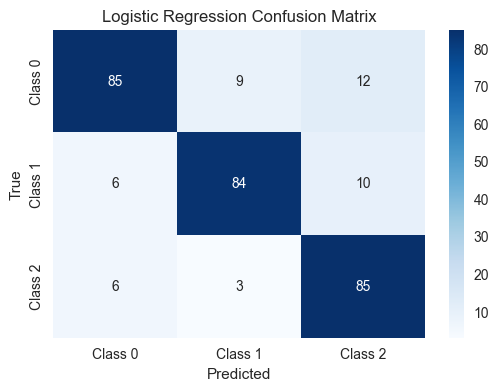

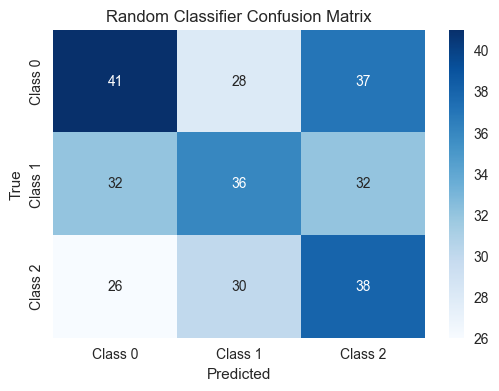

In [18]:
# Function to plot confusion matrix
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], 
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot for each classifier
plot_cm(y_test, y_pred_lr, 'Logistic Regression Confusion Matrix')
plot_cm(y_test, y_pred_dummy, 'Random Classifier Confusion Matrix')

### ROC Curves
Plot the ROC curve for the three classes. One curve for a class. Use the one-vs-rest approach. 

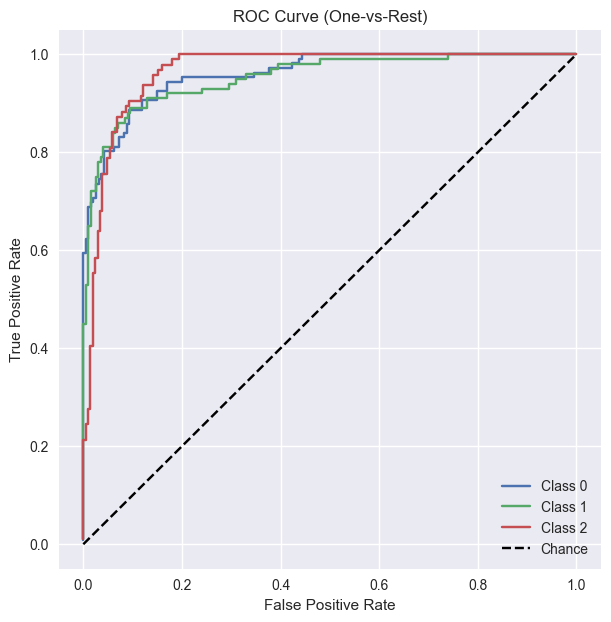

In [19]:
# TODO

num_classes = 3
plt.figure(figsize=(7, 7))

for cls in range(num_classes):
    y_score = clf_lr.predict_proba(X_test)[:, cls]
    y_true_bin = (y_test == cls).astype(int)
    thresholds = np.unique(y_score)[::-1]
    tpr_list = []
    fpr_list = []
    P = np.sum(y_true_bin == 1)
    N = np.sum(y_true_bin == 0)
    for thresh in thresholds:
        y_pred = (y_score >= thresh).astype(int)
        TP = np.sum((y_pred == 1) & (y_true_bin == 1))
        FP = np.sum((y_pred == 1) & (y_true_bin == 0))
        TPR = TP / P if P > 0 else 0
        FPR = FP / N if N > 0 else 0
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    plt.plot(fpr_list, tpr_list, label=f'Class {cls}')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()


### Sanity Check

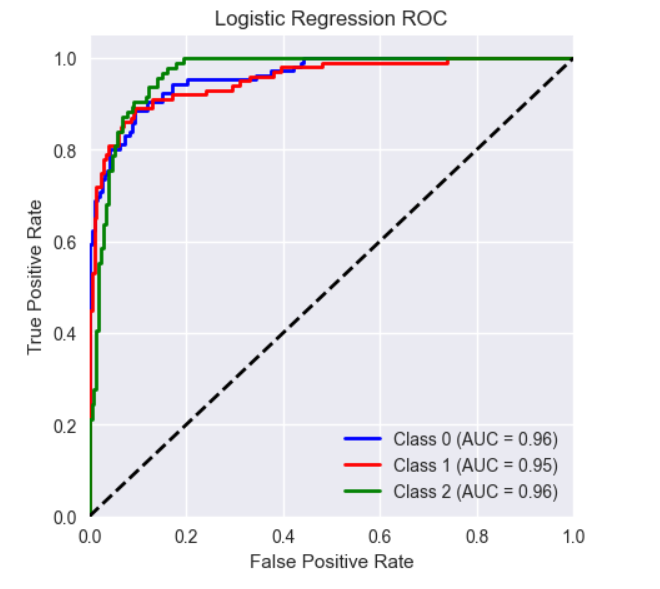

### The Precision Recall Curve

Look at the precision recall curve. Can you make them more attrative?

<Figure size 800x600 with 0 Axes>

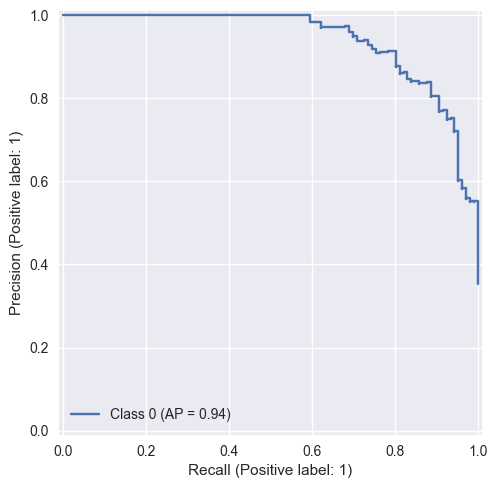

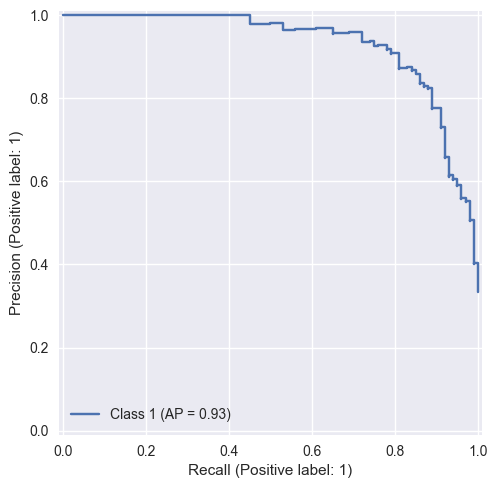

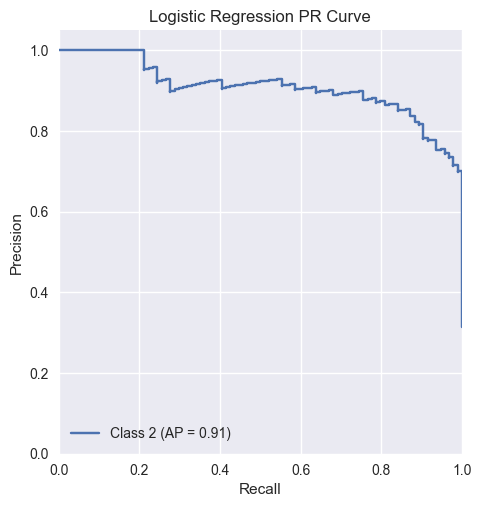

<Figure size 800x600 with 0 Axes>

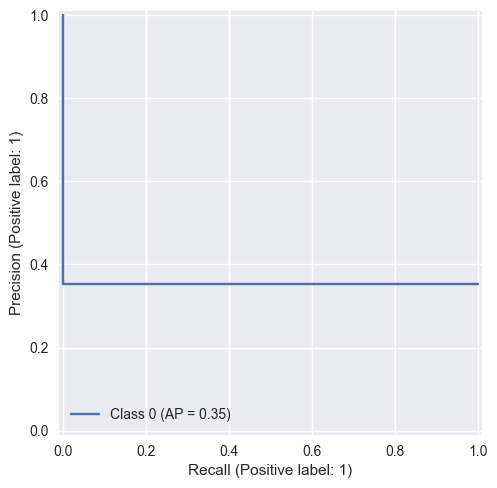

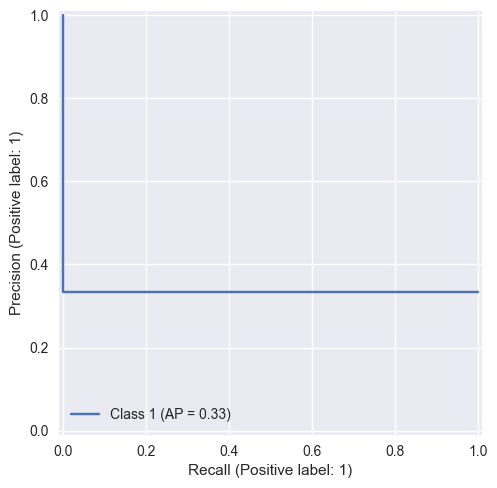

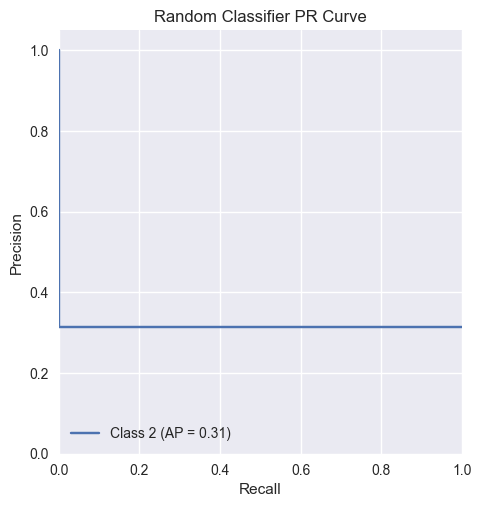

In [20]:
# Function to plot Precision-Recall curves using PrecisionRecallDisplay
def plot_pr_display(clf, X_test, y_test, title):
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    y_score = clf.predict_proba(X_test)
    plt.figure(figsize=(8, 6))
    
    for i in range(3):
        display = PrecisionRecallDisplay.from_predictions(y_test_bin[:, i], y_score[:, i], name=f'Class {i}')        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

# Plot for each classifier
plot_pr_display(clf_lr, X_test, y_test, 'Logistic Regression PR Curve')
plot_pr_display(clf_dummy, X_test, y_test, 'Random Classifier PR Curve')